# LIVER DISEASE DETERMINATION - FROM  BLOOD TEST DATA

## DataSet Overview

### DataSet Information

The first 5 variables are all blood tests which are thought to be sensitive to liver disorders that might arise from excessive alcohol consumption. Each line in the dataset constitutes the record of a single male individual.

Important note: The 7th field (selector) has been widely misinterpreted in the past as a dependent variable representing presence or absence of a liver disorder. This is incorrect [1]. The 7th field was created by BUPA researchers as a train/test selector. It is not suitable as a dependent variable for classification. The dataset does not contain any variable representing presence or absence of a liver disorder. Researchers who wish to use this dataset as a classification benchmark should follow the method used in experiments by the donor (Forsyth & Rada, 1986, Machine learning: applications in expert systems and information retrieval) and others (e.g. Turney, 1995, Cost-sensitive classification: Empirical evaluation of a hybrid genetic decision tree induction algorithm), who used the 6th field (drinks), after dichotomising, as a dependent variable for classification. Because of widespread misinterpretation in the past, researchers should take care to state their method clearly.

### Attribute Information

1. mcv mean corpuscular volume
2. alkphos alkaline phosphotase
3. sgpt alanine aminotransferase
4. sgot aspartate aminotransferase
5. gammagt gamma-glutamyl transpeptidase
6. drinks number of half-pint equivalents of alcoholic beverages drunk per day
7. selector field created by the BUPA researchers to split the data into train/test sets

### Data Location

* Data available from https://archive.ics.uci.edu/ml/datasets/Liver+Disorders

## NoteBook Set-Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize'] = (16, 9)

In [8]:
with open(r"bupa.data") as fp:
    df = pd.DataFrame([line.split(maxsplit=7, sep = ",") for line in fp])

## Data Preparation

In [9]:
names = ["mcv", "alkphos", "sgpt","sgot", "gammagt", "alcohol_cons", "selector_field"]
df.columns = names #set the column titles from the list defined above

In [10]:
selector_col = df.pop("selector_field") #target variable
df = df.astype("float") #use all of the features in the float format

In [11]:
df.head() #give us a quick preview of this data

,mcv,alkphos,sgpt,sgot,gammagt,alcohol_cons
0,85.0,92.0,45.0,27.0,31.0,0.0
1,85.0,64.0,59.0,32.0,23.0,0.0
2,86.0,54.0,33.0,16.0,54.0,0.0
3,91.0,78.0,34.0,24.0,36.0,0.0
4,87.0,70.0,12.0,28.0,10.0,0.0


## K-Means CLusering

### Scaled Features

In [12]:
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df)) #scaled the columns in the df
scaled_df.columns = names[:6] #reset the column names

In [13]:
scaled_df.head() #we can see that the dataframe's features have been scaled

,mcv,alkphos,sgpt,sgot,gammagt,alcohol_cons
0,0.526316,0.600000,0.271523,0.285714,0.089041,0.0
1,0.526316,0.356522,0.364238,0.350649,0.061644,0.0
2,0.552632,0.269565,0.192053,0.142857,0.167808,0.0
3,0.684211,0.478261,0.198675,0.246753,0.106164,0.0
4,0.578947,0.408696,0.052980,0.298701,0.017123,0.0


### K-Means Clustering

In [14]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 3).fit(scaled_df) #fit k-means cluster to scaled dataset

In [15]:
centroids = kmeans.cluster_centers_ #store the cluster centers
labels = kmeans.predict(scaled_df) #generate labels for each row of data
scaled_df['k_group'] = labels #assign these labels to the new column in the main dataframe

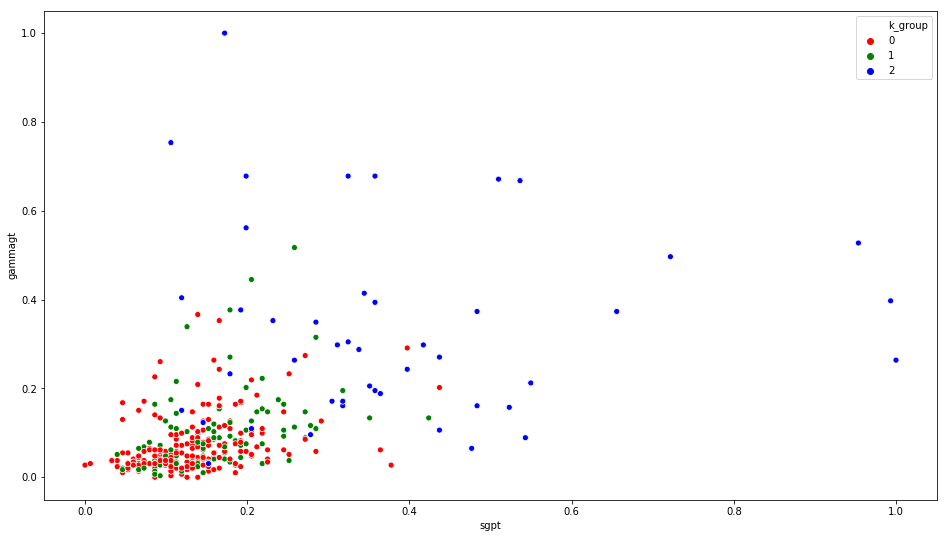

In [16]:
color_dict = dict({0:'red',
                  1:'green',
                  2: 'blue'}) #assign a dictionary for colour assignment

sns.scatterplot(x = 'sgpt', y = 'gammagt', hue = 'k_group',
                palette = color_dict, data = scaled_df)

# Data Understanding

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2132d4a8>,
      dtype=object)

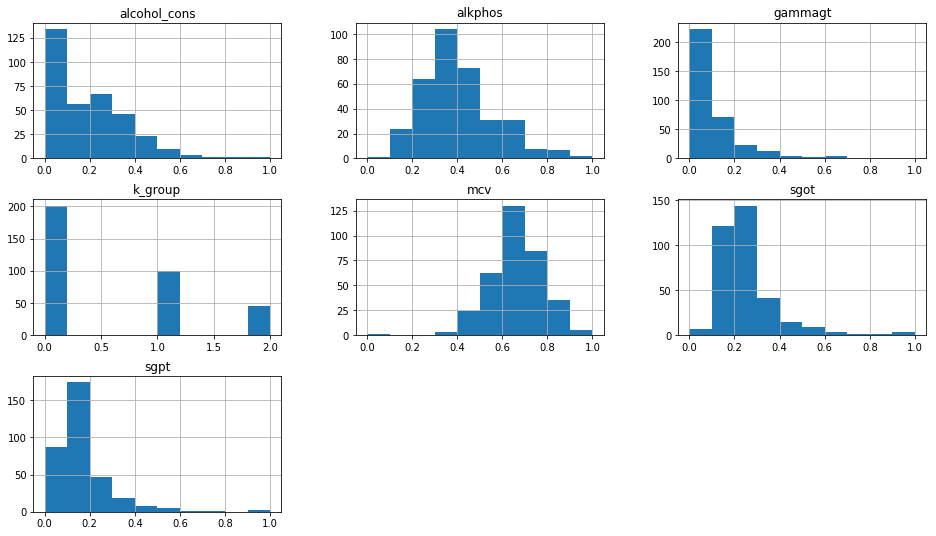

In [17]:
scaled_df.hist() #histogram view of each feature that we have

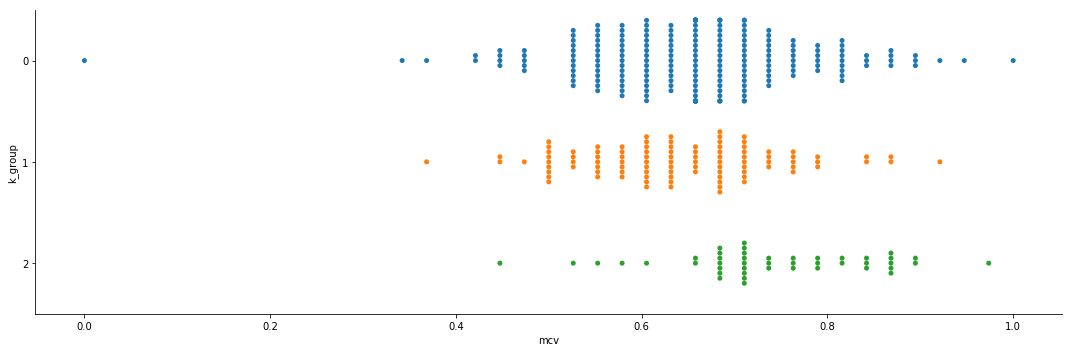

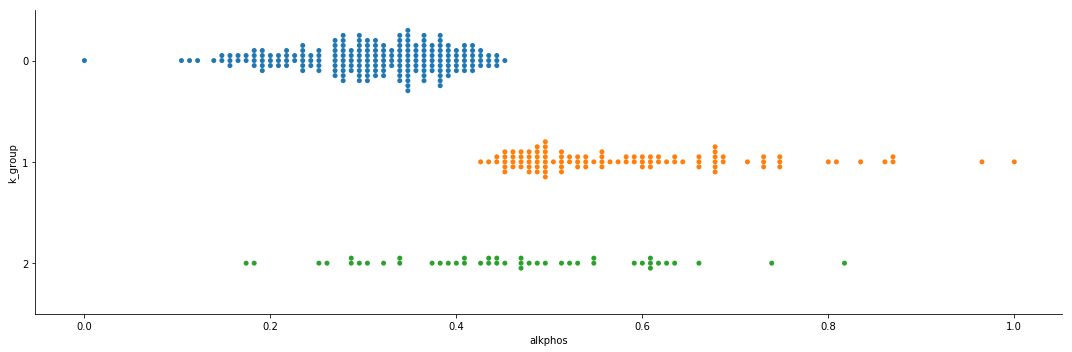

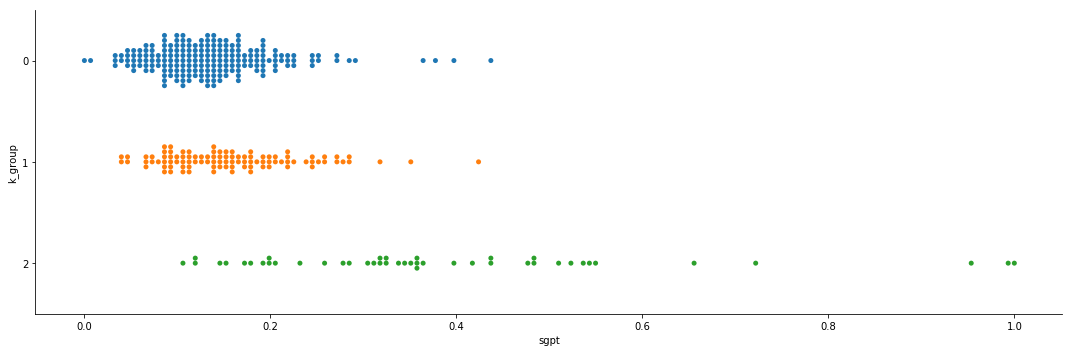

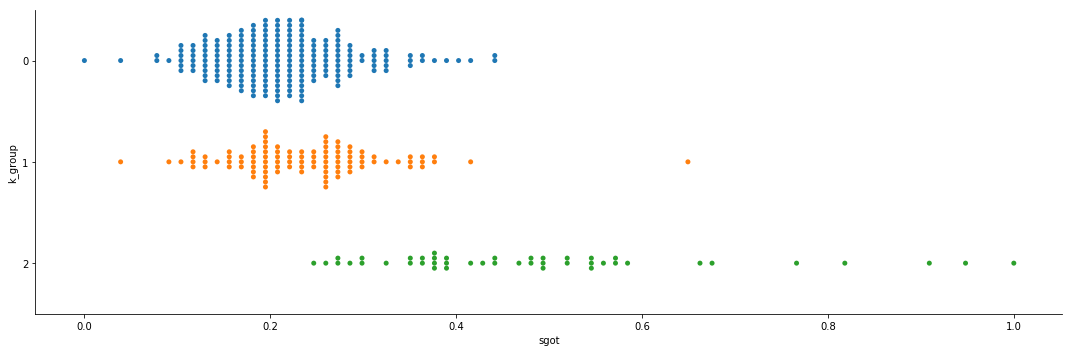

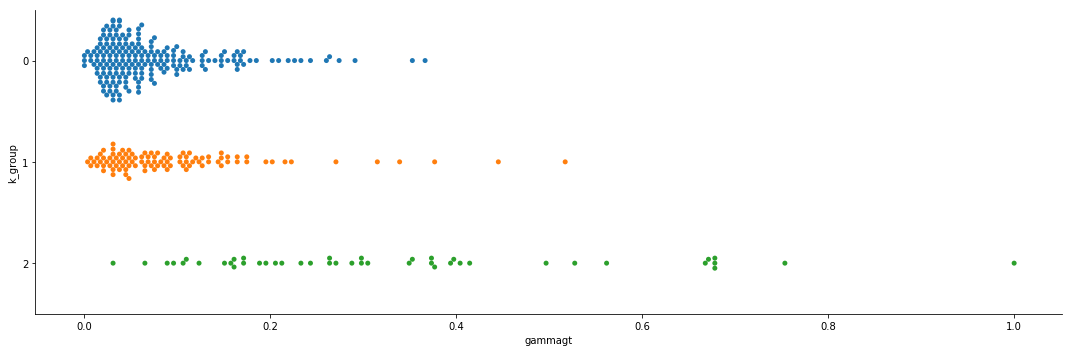

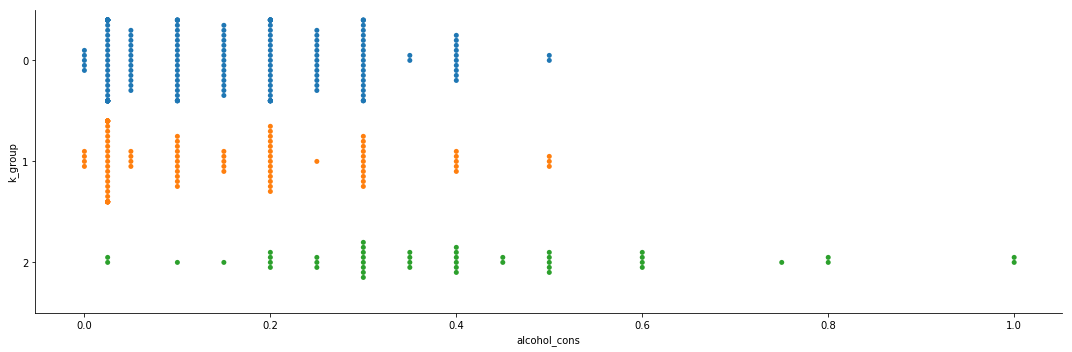

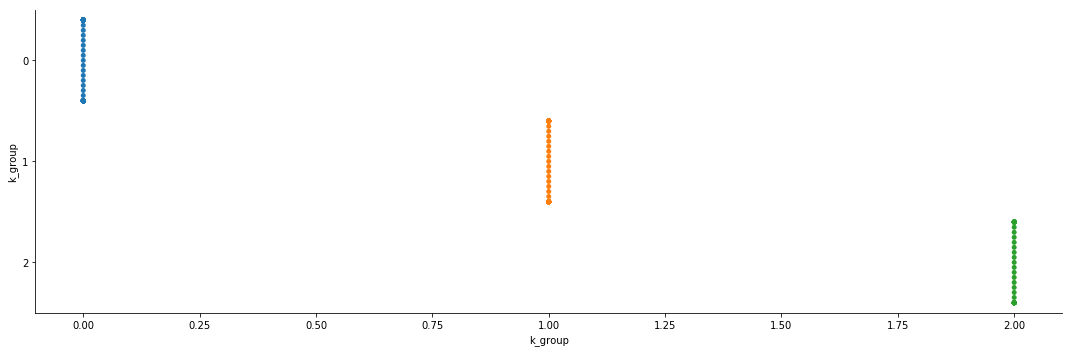

In [18]:
for i in list(scaled_df.columns):
    sns.catplot(x = i, y = "k_group", data = scaled_df, kind = "swarm", orient="h", aspect=3)

In [19]:
scaled_df['k_group'] = scaled_df['k_group'].astype("object")

/Users/alessiomorteo/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 1152x720 with 0 Axes>

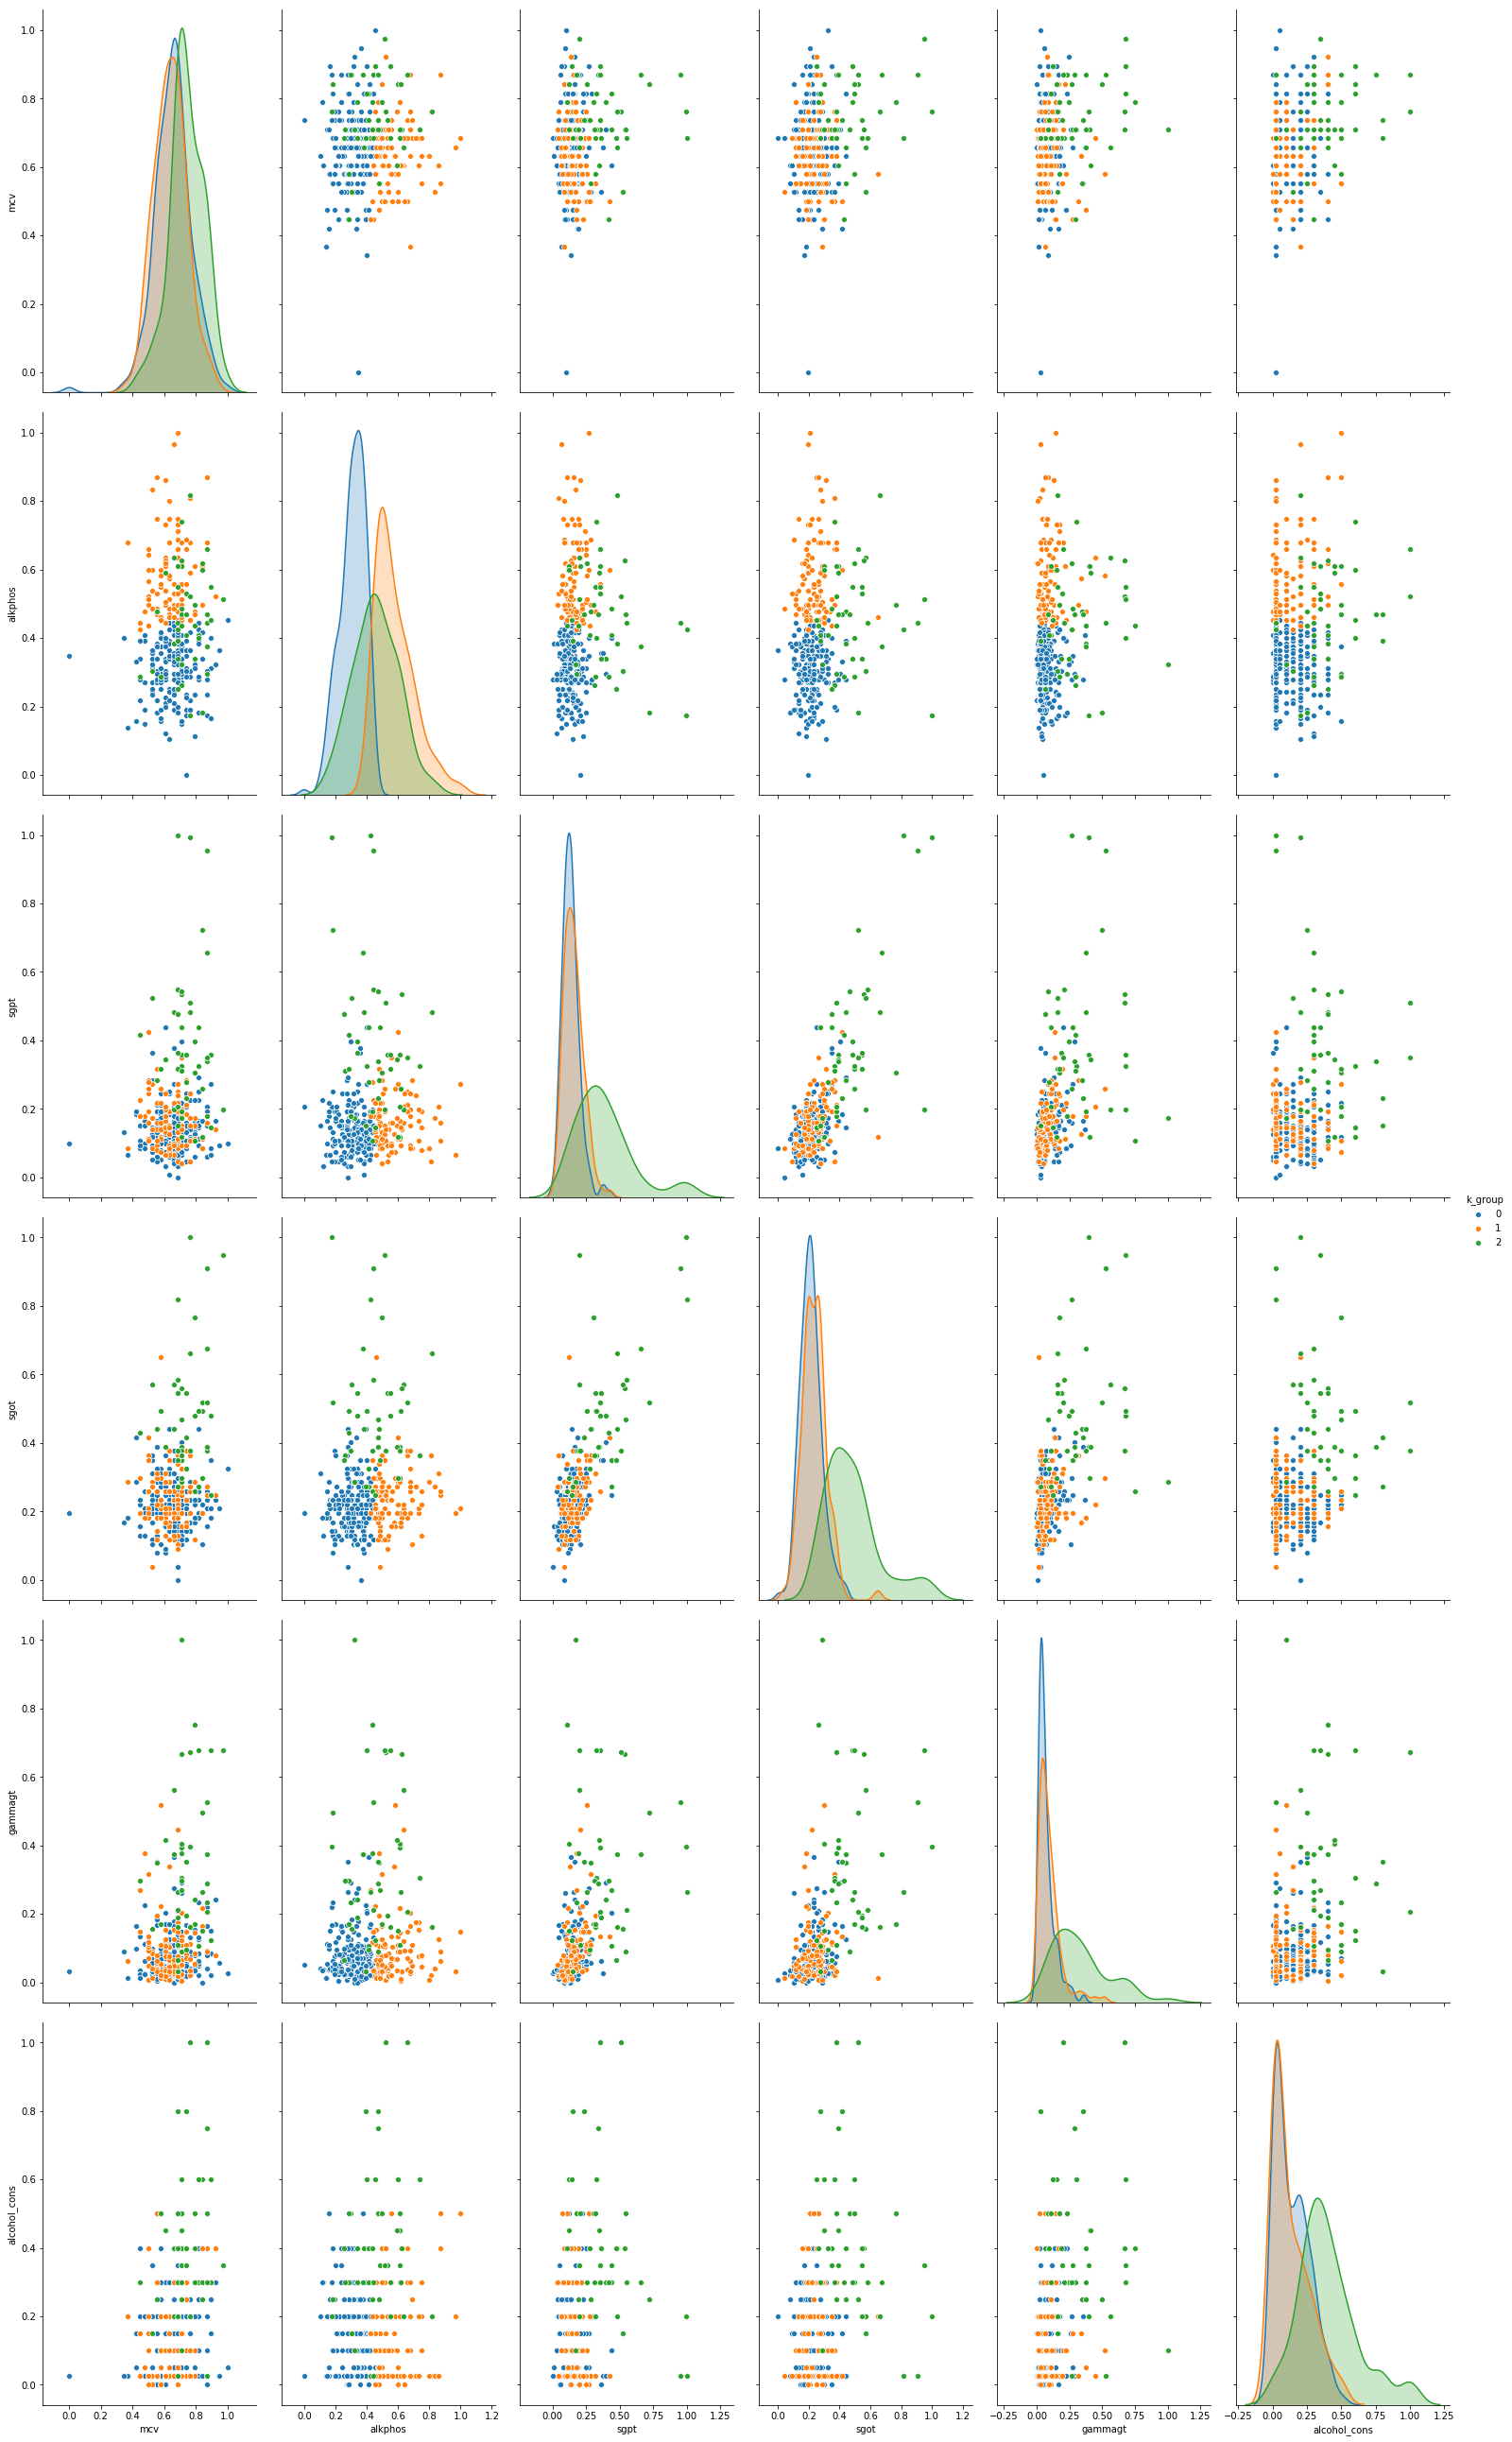

In [20]:
from matplotlib import rcParams
plt.figure(figsize=(16, 10))
sns.pairplot(scaled_df, hue="k_group", vars=["mcv", "alkphos", "sgpt", "sgot","gammagt",
                                              "alcohol_cons"], height=6, aspect=0.6)

### Insights
* Alkphos alkaline phosphotase - raised with poor liver function (Raised levels of ALP are usually due to a disorder of either the bone or liver)
* Alanine aminotrasnferase - When the liver is damaged, ALT is released into the bloodstream. 
* Aspartate aminotransferase - Body releases more when your liver is damaged
* MCV - how big are the red blood cells (erythrocytes), increases with alcohol consumption - 80-96 is normal
* GGT is high with liver damage.


### Find the Suitable Number of Clusters to Utilise

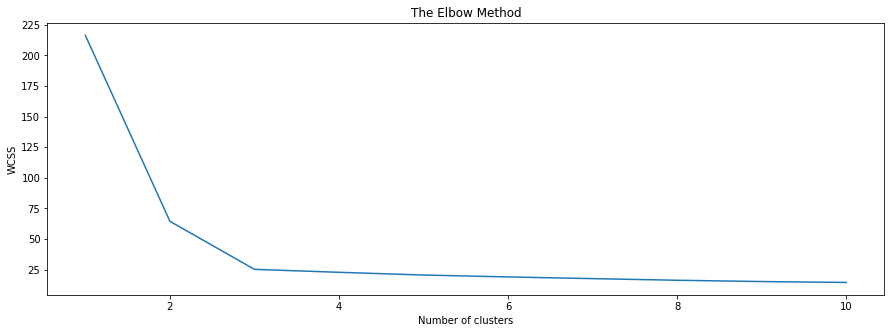

In [21]:
# find the appropriate cluster number
plt.figure(figsize=(15, 5))
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## MODELLING - RANDOM FOREST HYPERPARAMETER TUNING

### Set-Up

In [22]:
scaled_df.iloc[:,-1] = scaled_df.iloc[:,-1].astype("int") #target is considered as a                                                                    categorical number (integer)

In [23]:
# Split dataset into Training Set and Test Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_df.iloc[:,:6],
                                                    scaled_df.iloc[:,-1],
                                                    test_size = 0.25,
                                                    random_state = 42)

### Train Model

In [24]:
# fit model no training data
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
model = SVC(kernel = 'linear', gamma = 'auto', probability = True)
model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

### Model Predictions

In [25]:
y_pred = model.predict(X_test) #make a prediction on each test set instance
predictions = [round(value) for value in y_pred] #round the values

In [26]:
class_probabilities = pd.DataFrame(model.predict_proba(X_test)) #obtain class probabilities for the x_test
for i in range(3):  
    class_probabilities.iloc[:, i] = (class_probabilities.iloc[:, i] * 100) #convert to a percentage format
class_probabilities.head() 

,0,1,2
0,99.945571,0.049514,0.004916
1,5.408702,65.030664,29.560633
2,99.885973,0.095375,0.018652
3,2.199153,97.350126,0.450721
4,1.361722,92.723076,5.915203


### Model Performance

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [27]:
# evaluate predictions
print("Model accuracy: {:.2f}%".format(accuracy_score(y_test, predictions) * 100.0))
print("Model F1 (macro): {:.3f}".format(f1_score(y_test, predictions, average = "macro")))

Model accuracy: 88.51%
Model F1 (macro): 0.873


[Text(62.5, 0.5, 'Actual Class'), Text(0.5, 35.5, 'Predicted Class')]

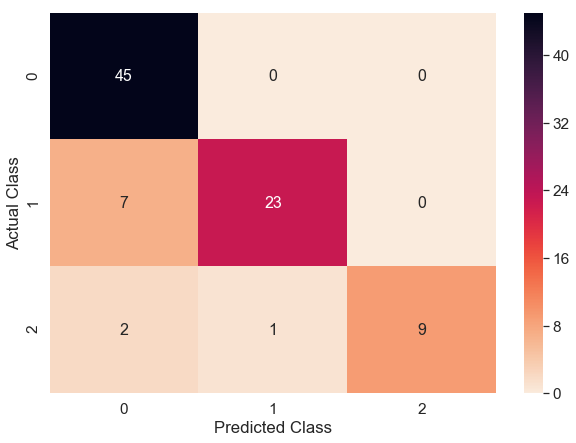

In [29]:
df_cm = confusion_matrix(y_test, predictions)
cmap = sns.cm.rocket_r
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
ax = sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap = cmap) #generate the confusion matrix plot
ax.set(xlabel = 'Predicted Class', ylabel = 'Actual Class') #assign x and y axis labels

### Feature Importance

Text(0.5, 1.0, 'Model Feature Importances')

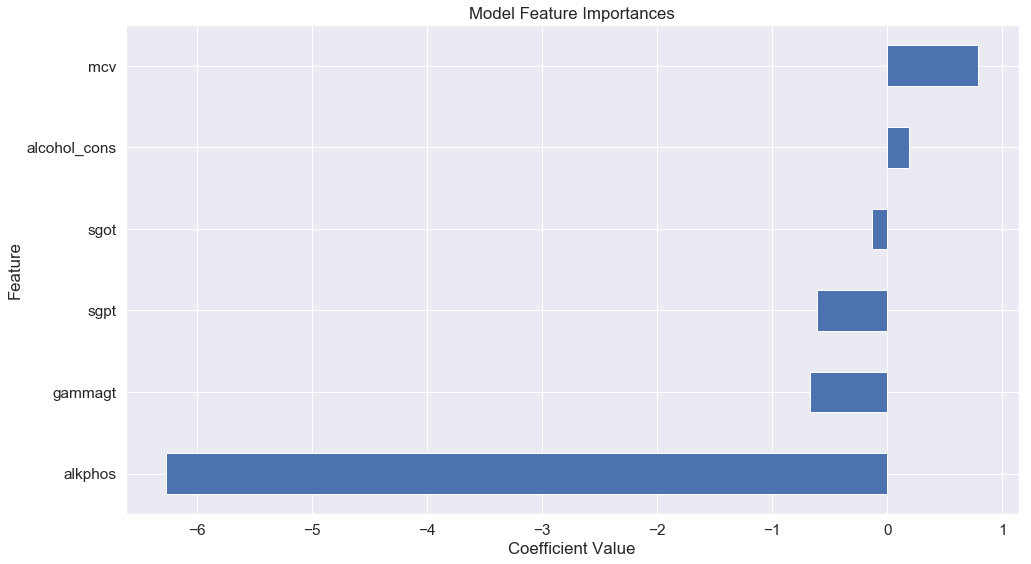

In [30]:
model_coefficients = pd.Series(model.coef_[0], index = scaled_df.iloc[:, :6].columns) #store coefficients in dataframe using column labels for each respective coefficient
model_coefficients.sort_values(ascending = True).plot(kind = 'barh') #plot the feature importance
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Model Feature Importances')